<h1> Samplers, Collate Functions, and DataLoaders

In [1]:
from imports import *
from utils import *
from tfms_torch import *
from tfms_albumentations import *
from video_dataset import *

In [2]:
data = VideoDataset('../data/train/', frames_per_clip=16)

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


## Samplers

torchvision's `RandomClipSampler`, `UniformClipSampler`, and a new `FirstClipSampler`

### RandomClipSampler

<br>

Taken from [`torchvision.datasets.samplers.RandomClipSampler`](https://github.com/pytorch/vision/blob/95131de394543a7c34bd51932bdfce21dae516c1/torchvision/datasets/samplers/clip_sampler.py#L142). <br>
Redefining the class -- commenting out the `TypeError` chunk since we've modified torchvision's original code

In [3]:
#export

class RandomClipSampler(torch.utils.data.Sampler):
    """
    Samples at most `max_video_clips_per_video` clips for each video randomly

    Arguments:
        video_clips (VideoClips): video clips to sample from
        max_clips_per_video (int): maximum number of clips to be sampled per video
    """
    def __init__(self, video_clips, max_clips_per_video):
        #if not isinstance(video_clips, visionmod.video_utils.VideoClips):
        #    raise TypeError("Expected video_clips to be an instance of VideoClips, "
        #                    "got {}".format(type(video_clips)))
        self.video_clips = video_clips
        self.max_clips_per_video = max_clips_per_video

    def __iter__(self):
        idxs = []
        s = 0
        # select at most max_clips_per_video for each video, randomly
        for c in self.video_clips.clips:
            length = len(c)
            size = min(length, self.max_clips_per_video)
            sampled = torch.randperm(length)[:size] + s
            s += length
            idxs.append(sampled)
        idxs = torch.cat(idxs)
        # shuffle all clips randomly
        perm = torch.randperm(len(idxs))
        idxs = idxs[perm].tolist()
        return iter(idxs)

    def __len__(self):
        return sum(min(len(c), self.max_clips_per_video) for c in self.video_clips.clips)

In [4]:
data.get_info()

,Filename,Class,# Frames,FPS,# Subclips
0,c1-sample1.mp4,class1,32,25.0,17
1,c1-sample2.mp4,class1,47,25.0,32
2,c2-sample1.mp4,class2,17,25.0,2
3,c2-sample2.mp4,class2,13,25.0,0


/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/torchvision-0.5.0a0+5eee011-py3.7-macosx-10.7-x86_64.egg/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.


12
38
49


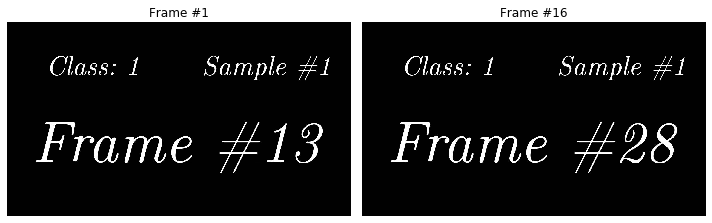

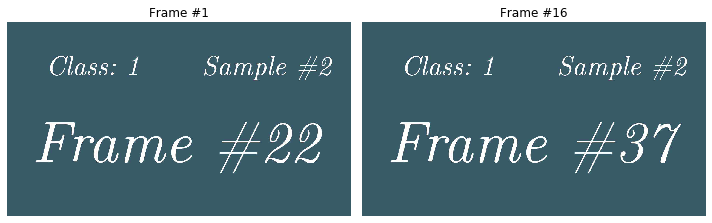

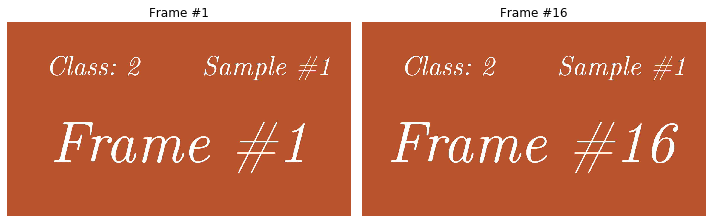

In [5]:
plot = lambda i: plot_adjacent(data[i][0], j=15, figsize=(10, 6))
x = RandomClipSampler(data.video_clips, 1)
for i in x: 
    print(i)
    plot(i)

### UniformClipSampler

<br>

Taken from [`torchvision.datasets.samplers.UniformClipSampler`](https://github.com/pytorch/vision/blob/95131de394543a7c34bd51932bdfce21dae516c1/torchvision/datasets/samplers/clip_sampler.py#L99)
Redefining the class -- commenting out the `TypeError` chunk since we've modified torchvision's original code

In [6]:
#export

class UniformClipSampler(torch.utils.data.Sampler):
    """
    Sample `num_video_clips_per_video` clips for each video, equally spaced.
    When number of unique clips in the video is fewer than num_video_clips_per_video,
    repeat the clips until `num_video_clips_per_video` clips are collected
    Arguments:
        video_clips (VideoClips): video clips to sample from
        num_clips_per_video (int): number of clips to be sampled per video
    """
    def __init__(self, video_clips, num_clips_per_video):
        #if not isinstance(video_clips, torchvision.datasets.video_utils.VideoClips):
        #    raise TypeError("Expected video_clips to be an instance of VideoClips, "
        #                    "got {}".format(type(video_clips)))
        self.video_clips = video_clips
        self.num_clips_per_video = num_clips_per_video

    def __iter__(self):
        idxs = []
        s = 0
        # select num_clips_per_video for each video, uniformly spaced
        for c in self.video_clips.clips:
            length = len(c)
            if length == 0:
                # corner case where video decoding fails
                continue

            sampled = (
                torch.linspace(s, s + length - 1, steps=self.num_clips_per_video)
                .floor()
                .to(torch.int64)
            )
            s += length
            idxs.append(sampled)
        idxs = torch.cat(idxs).tolist()
        return iter(idxs)

    def __len__(self):
        return sum(
            self.num_clips_per_video for c in self.video_clips.clips if len(c) > 0
        )


In [7]:
data.get_info()

,Filename,Class,# Frames,FPS,# Subclips
0,c1-sample1.mp4,class1,32,25.0,17
1,c1-sample2.mp4,class1,47,25.0,32
2,c2-sample1.mp4,class2,17,25.0,2
3,c2-sample2.mp4,class2,13,25.0,0


Here, it samples the first and last subclips. This may change depending on a bunch of factors, but the distribution remains uniform

0
16
17
48
49
50


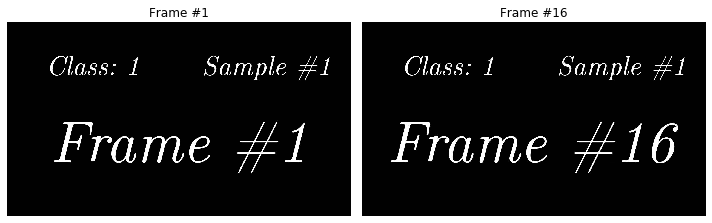

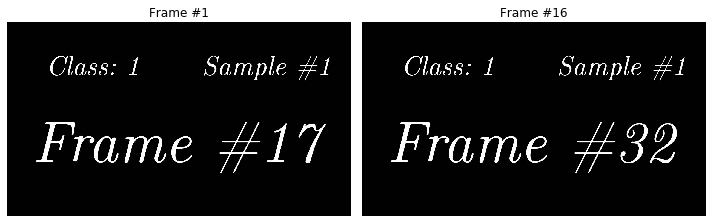

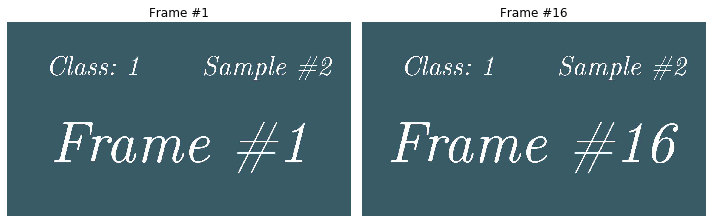

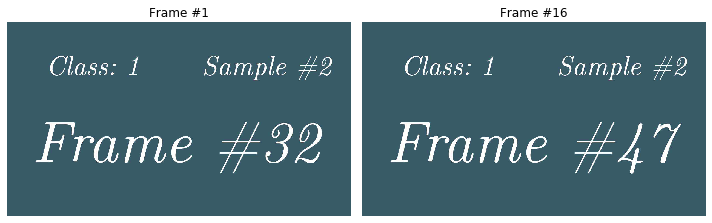

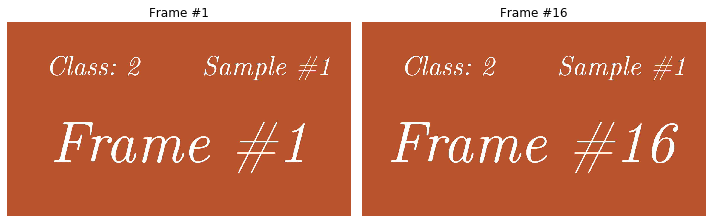

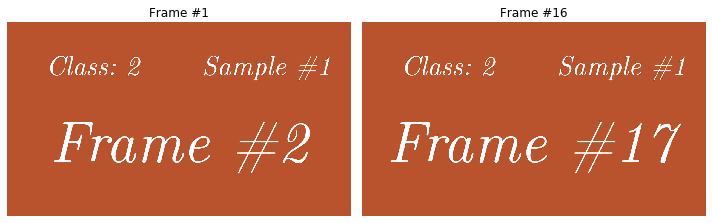

In [8]:
x = UniformClipSampler(data.video_clips, 2)

for i in x: 
    print(i)
    plot(i)

### FirstClipSampler

<br>

A new sampler that returns only the first `max_clips` subclips. <br>
This is useful if the first few frames of your video are essential to your model.

In [9]:
#export

class FirstClipSampler(torch.utils.data.Sampler):
    """
    Samples at most `max_video_clips_per_video` clips for each video sequentially

    Arguments:
        video_clips (VideoClips): video clips to sample from
        max_clips_per_video (int): maximum number of clips to be sampled per video
    """
    def __init__(self, video_clips, max_clips_per_video):
        #if not isinstance(video_clips, visionmod.video_utils.VideoClips):
        #    raise TypeError("Expected video_clips to be an instance of VideoClips, "
        #                    "got {}".format(type(video_clips)))
        self.video_clips = video_clips
        self.max_clips_per_video = max_clips_per_video

    def __iter__(self):
        idxs = []
        s = 0
        # select at most max_clips_per_video for each video, sequentially
        for c in self.video_clips.clips:
            length = len(c)
            size = min(length, self.max_clips_per_video)
            sampled = torch.arange(length)[:size] + s # the only change from `RandomClipSampler`
            s += length
            idxs.append(sampled)
        idxs = torch.cat(idxs)
        # shuffle all clips randomly
        perm = torch.randperm(len(idxs))
        idxs = idxs[perm].tolist()
        return iter(idxs)

    def __len__(self):
        return sum(min(len(c), self.max_clips_per_video) for c in self.video_clips.clips)

18
17
0
50
1
49


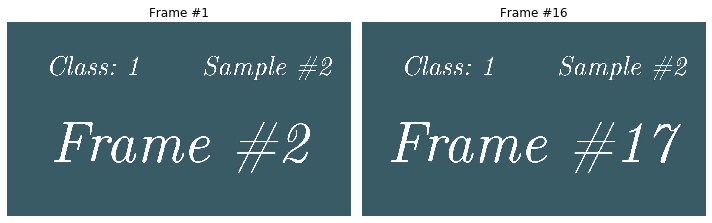

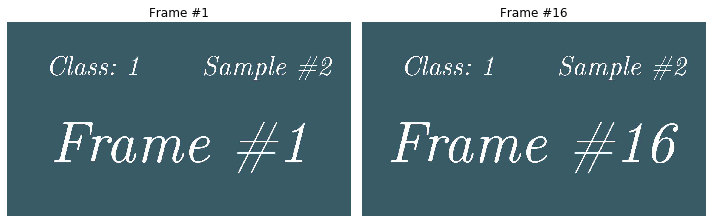

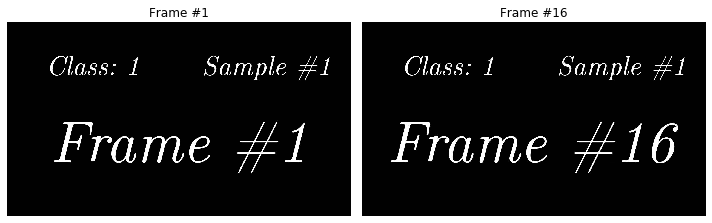

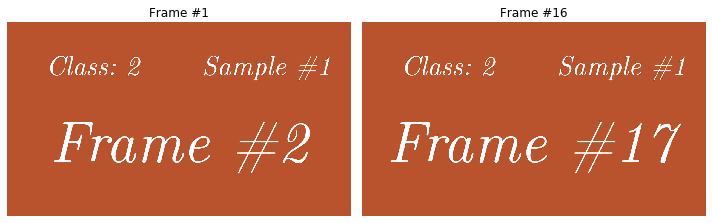

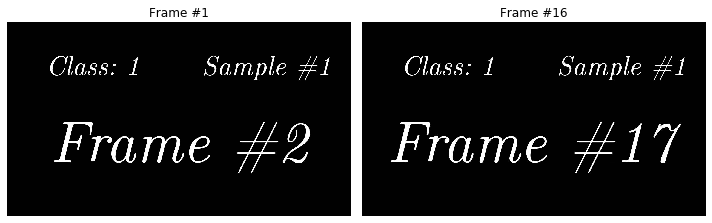

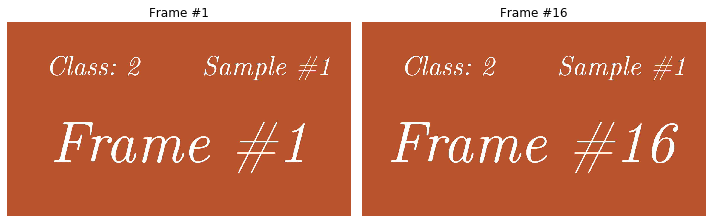

In [10]:
x = FirstClipSampler(data.video_clips, 2)

for i in x: 
    print(i)
    plot(i)

## Collate Function

Ported from [torchvision's reference script](https://github.com/pytorch/vision/blob/95131de394543a7c34bd51932bdfce21dae516c1/references/video_classification/train.py) 

In [11]:
#export
from torch.utils.data.dataloader import default_collate
def collate_fn(batch):
    # remove audio from the batch
    batch = [(d[0], d[2]) for d in batch]
    return default_collate(batch)

In [12]:
x = data[0]
collated_x = x[0], x[2]
print(collated_x[0].shape, collated_x[1])

torch.Size([16, 900, 1600, 3]) 0


## DataLoader

Now that we have all the pieces, we pass it into a DataLoader to ensure everything is working as expected.

In [13]:
sampler = FirstClipSampler(data.video_clips, max_clips_per_video=4)
data = VideoDataset('../data/train/', frames_per_clip=8)
data.get_info()

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


,Filename,Class,# Frames,FPS,# Subclips
0,c1-sample1.mp4,class1,32,25.0,25
1,c1-sample2.mp4,class1,47,25.0,40
2,c2-sample1.mp4,class2,17,25.0,10
3,c2-sample2.mp4,class2,13,25.0,6


In [14]:
dl = torch.utils.data.DataLoader(dataset=data, batch_size=4, sampler=sampler, collate_fn=collate_fn)

In [15]:
xb, yb = next(iter(dl))

In [16]:
xb.shape
yb.shape

torch.Size([4, 8, 900, 1600, 3])

torch.Size([4])

success!

## Export

In [17]:
!python notebook2script.py 04_dataloader.ipynb

Converted 04_dataloader.ipynb to dataloader.py
